**Разработка модели**

In [ ]:
# импорт необходимых библиотек
import os
import cv2
import time
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC,Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score # импорт необходимых метрик
from tensorflow.keras.applications import Xception,VGG19,ResNet50,InceptionResNetV2,ResNet152V2,EfficientNetB2,ConvNeXtTiny # импорт необходимых алгоритмов
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,GlobalMaxPooling2D,Dropout # для построения нейронов
random.seed(555)

import zipfile # для распаковки датасета
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# распаковка датасета
file = '/content/drive/My Drive/Dataset/fc-dataset.zip'
with zipfile.ZipFile(file, mode='r') as archive:
  archive.extractall()

In [ ]:
# указание путей
dir_train = '/content/casting_data/casting_data/train'
dir_test = '/content/casting_data/casting_data/test'

In [ ]:
# тренировочный датасет
dir_train_def = dir_train + '/def_front/'
dir_train_ok = dir_train + '/ok_front/'
# тестовый датасет
dir_test_def = dir_test + '/def_front/'
dir_test_ok = dir_test + '/ok_front/'

In [ ]:
image_files_train_def = os.listdir(dir_train_def)
image_files_train_ok = os.listdir(dir_train_ok)

In [ ]:
n = len(image_files_train_def)
m = len(image_files_train_ok)
print(f'количество всех изображений в обучающем наборе равно {n+m}')
print(f'количество изображений c "дефектными"(def) деталями равно {n}')
print(f'количество изображений с "исправными"(ok) деталями равно {m}')
print(f'соотношение между изображениями с исправными(ok) и дефектными(def) деталями равно {m/n}')

количество всех изображений в обучающем наборе равно 6633
количество изображений c "дефектными"(def) деталями равно 3758
количество изображений с "исправными"(ok) деталями равно 2875
соотношение между изображениями с исправными(ok) и дефектными(def) деталями равно 0.7650345928685471


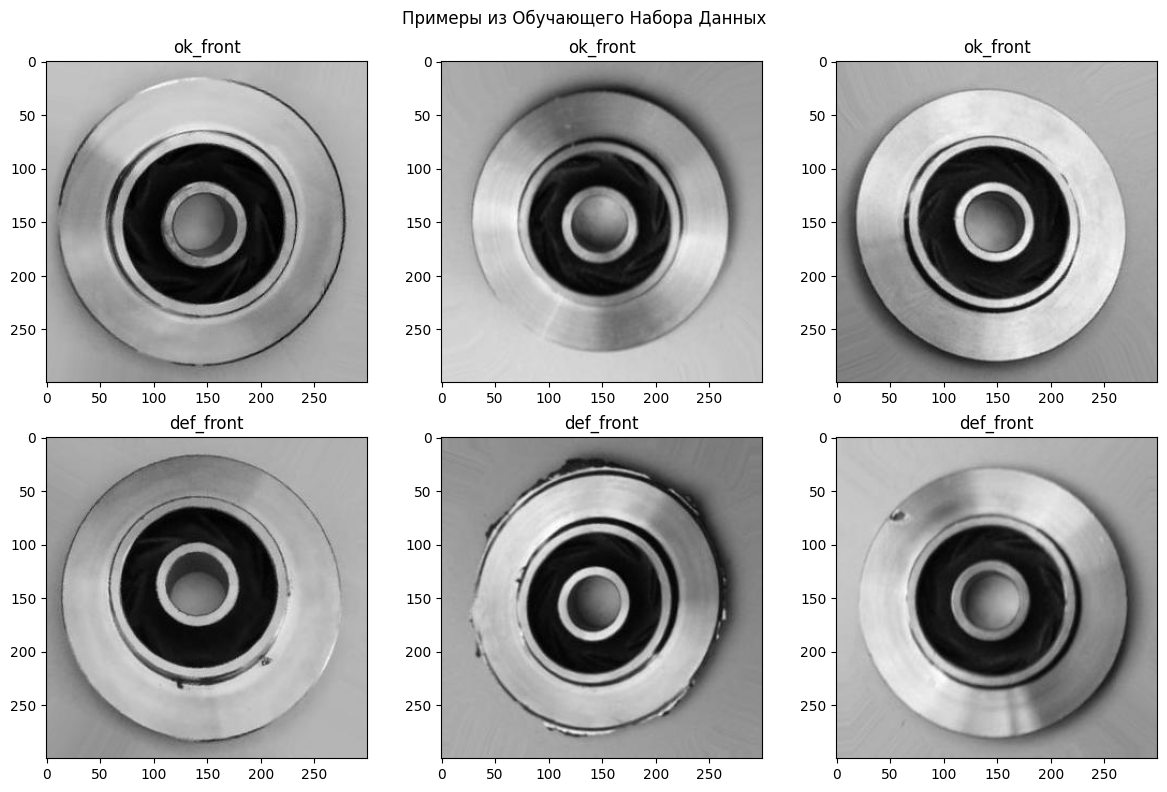

In [ ]:
# Функция для получения списка случайных файлов изображений из каталога
def get_random_image_files(directory, num_files):
    files = os.listdir(directory)
    random.shuffle(files)
    return files[:num_files]

# Создаем сетку 2х3 для изображений "ok_front"
plt.figure(figsize=(12, 8))
plt.suptitle('Примеры из Обучающего Набора Данных')

for i in range(3):
    plt.subplot(2, 3, i + 1)
    image_files_ok = get_random_image_files(dir_train_ok, 3)
    img = Image.open(os.path.join(dir_train_ok, image_files_ok[i]))
    plt.imshow(img)
    plt.title('ok_front')

# Создаем сетку 2х3 для изображений "def_front"
for i in range(3):
    plt.subplot(2, 3, i + 4)
    image_files_def = get_random_image_files(dir_train_def, 3)
    img = Image.open(os.path.join(dir_train_def, image_files_def[i]))
    plt.imshow(img)
    plt.title('def_front')

plt.tight_layout()
plt.show()

In [ ]:
# то же самое для ok_front
img = Image.open(os.path.join(dir_train_def, image_files_def[0]))
img.size, img.mode

((300, 300), 'RGB')

In [ ]:
# Мы можем наблюдать, что можем генерировать больше примеров, просто используя вращения
img_size = (300,300)
rand_seed = 555
batch_size = 32
epochs = 15

In [ ]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,   # горизонтальное отображение
    vertical_flip=True,   # вертикальное отображение
    rotation_range=40,   # вращение на 40 градусов
    brightness_range=[0.2, 1.5],
    validation_split=0.4,
)

test_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
arg_train = {'target_size': img_size,
             'color_mode': 'rgb',
             'classes': {'ok_front': 0,
                         'def_front': 1},
             'class_mode': 'binary',
             'batch_size': batch_size,
             'seed': rand_seed}

arg_test = {'target_size': img_size,
            'color_mode': 'rgb',
            'classes': {'ok_front': 0,
                        'def_front': 1},
            'class_mode': 'binary',
            'batch_size': batch_size,
            'seed': rand_seed,
            'shuffle': False}
# 80%
train_set = train_gen.flow_from_directory(directory=dir_train,
                                          subset='training',
                                          **arg_train)
#20%
valid_set = train_gen.flow_from_directory(directory=dir_train,
                                          subset='validation',
                                          **arg_train)

# for the 0 and 1 ...etc
test_set = test_gen.flow_from_directory(directory=dir_test,
                                        **arg_test)

Found 3980 images belonging to 2 classes.
Found 2653 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [ ]:
def load_pretrained_model(model_name):
    if model_name == 'Xception':
        return Xception(weights='imagenet', include_top=False)
    elif model_name == 'ResNet50':
        return ResNet50(weights='imagenet', include_top=False)
    elif model_name == 'InceptionResNetV2':
        return InceptionResNetV2(weights='imagenet', include_top=False)
    elif model_name == 'ResNet152V2':
        return ResNet152V2(weights='imagenet', include_top=False)

def create_and_compile_model(base_model, learning_rate=0.01):
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer='l1_l2')(x)
    x = Dense(128, activation='relu', kernel_regularizer='l1_l2')(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Изменяем количество выходных нейронов и активацию
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(lr=learning_rate),
                  loss='binary_crossentropy',  # Изменение функции потерь
                  metrics=['accuracy', AUC(), Precision(), Recall()])  # Обновление метрик

    return model

def train_and_evaluate_model(model, model_name, train_set, valid_set, test_set, epochs=10, batch_size=32):
    model_checkpoint = ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_auc',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    )

    # Старт таймера
    start_time = time.time()

    history = model.fit(
        train_set,
        steps_per_epoch=train_set.samples // batch_size,
        epochs=epochs,
        validation_data=valid_set,
        validation_steps=valid_set.samples // batch_size,
        callbacks=[model_checkpoint]
    )

    # Стоп таймера
    end_time = time.time()
    training_time = end_time - start_time

    # Оценка модели на тестовом наборе
    test_loss, *test_metrics = model.evaluate(test_set, steps=test_set.samples // batch_size)
    test_acc = test_metrics[0]
    test_auc = test_metrics[1]
    test_precision = test_metrics[2]
    test_recall = test_metrics[3]

    # Запуск оценочного таймера
    evaluation_time = time.time() - end_time

    # Распечатка результатов
    print(f"model: {model_name}")
    print(f"Test accuracy: {test_acc * 100:.2f}%")
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Evaluation time: {evaluation_time:.2f} seconds")

    y_true = test_set.classes
    y_pred = model.predict(test_set)
    y_pred_classes = (y_pred > 0.5).astype(int)  # Преобразование в 0 или 1 на основе порогового значения
    cm = confusion_matrix(y_true, y_pred_classes)
    report = classification_report(y_true, y_pred_classes)
    auc = roc_auc_score(y_true, y_pred)

    return test_acc, cm, report, auc, test_precision, test_recall, history.history

In [ ]:
%%time

model_names = ['Xception', 'InceptionResNetV2', 'ResNet152V2']
results = {}

for model_name in model_names:
    print(f"Training model: {model_name}")
    base_model = load_pretrained_model(model_name)
    model = create_and_compile_model(base_model)
    test_acc, cm, report, auc, precision, recall, history = train_and_evaluate_model(model,
                                                         model_name,
                                                         train_set,
                                                         valid_set,
                                                         test_set,
                                                         epochs,
                                                         batch_size)

    results[model_name] = {
        'test_accuracy': test_acc,
        'confusion_matrix': cm,
        'classification_report': report,
        'roc_auc': auc,
        'history': history
    }

Training model: Xception
83683744/83683744 [==============================] - 5s 0us/step


Epoch 1/15
124/124 [==============================] - ETA: 0s - loss: 33.6299 - accuracy: 0.7918 - auc: 0.8697 - precision: 0.8025 - recall: 0.8384
Epoch 1: val_auc improved from -inf to 0.97269, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 209s 2s/step - loss: 33.6299 - accuracy: 0.7918 - auc: 0.8697 - precision: 0.8025 - recall: 0.8384 - val_loss: 2.7081 - val_accuracy: 0.8868 - val_auc: 0.9727 - val_precision: 0.9837 - val_recall: 0.8137
Epoch 2/15
124/124 [==============================] - ETA: 0s - loss: 1.7887 - accuracy: 0.8875 - auc: 0.9566 - precision: 0.9080 - recall: 0.8918
Epoch 2: val_auc improved from 0.97269 to 0.98851, saving model to best_model.h5
124/124 [==============================] - 195s 2s/step - loss: 1.7887 - accuracy: 0.8875 - auc: 0.9566 - precision: 0.9080 - recall: 0.8918 - val_loss: 1.3713 - val_accuracy: 0.8876 - val_auc: 0.9885 - val_precision: 0.8411 - val_recall: 0.9886
Epoch 3/15
124/124 [==============================] - ETA: 0s - loss: 1.2180 - accuracy: 0.9174 - auc: 0.9755 - precision: 0.9365 - recall: 0.9164
Epoch 3: val_auc improved from 0.98851 to 0.98996, saving model to best_model.h5
124/124 [==============================] - 186s 2s/

Epoch 1/15
124/124 [==============================] - ETA: 0s - loss: 39.7669 - accuracy: 0.7827 - auc_1: 0.8486 - precision_1: 0.7983 - recall_1: 0.8247

124/124 [==============================] - 218s 2s/step - loss: 39.7669 - accuracy: 0.7827 - auc_1: 0.8486 - precision_1: 0.7983 - recall_1: 0.8247 - val_loss: 4.7429 - val_accuracy: 0.9444 - val_auc_1: 0.9860 - val_precision_1: 0.9806 - val_recall_1: 0.9198
Epoch 2/15
124/124 [==============================] - ETA: 0s - loss: 2.8102 - accuracy: 0.9243 - auc_1: 0.9788 - precision_1: 0.9330 - recall_1: 0.9334

124/124 [==============================] - 197s 2s/step - loss: 2.8102 - accuracy: 0.9243 - auc_1: 0.9788 - precision_1: 0.9330 - recall_1: 0.9334 - val_loss: 1.8331 - val_accuracy: 0.9562 - val_auc_1: 0.9933 - val_precision_1: 0.9511 - val_recall_1: 0.9723
Epoch 3/15
124/124 [==============================] - ETA: 0s - loss: 1.4858 - accuracy: 0.9628 - auc_1: 0.9921 - precision_1: 0.9687 - recall_1: 0.9656

124/124 [==============================] - 194s 2s/step - loss: 1.4858 - accuracy: 0.9628 - auc_1: 0.9921 - precision_1: 0.9687 - recall_1: 0.9656 - val_loss: 1.2267 - val_accuracy: 0.9676 - val_auc_1: 0.9930 - val_precision_1: 0.9958 - val_recall_1: 0.9469
Epoch 4/15
124/124 [==============================] - ETA: 0s - loss: 1.1028 - accuracy: 0.9618 - auc_1: 0.9924 - precision_1: 0.9759 - recall_1: 0.9563

124/124 [==============================] - 191s 2s/step - loss: 1.1028 - accuracy: 0.9618 - auc_1: 0.9924 - precision_1: 0.9759 - recall_1: 0.9563 - val_loss: 0.9883 - val_accuracy: 0.9657 - val_auc_1: 0.9949 - val_precision_1: 0.9539 - val_recall_1: 0.9872
Epoch 5/15
124/124 [==============================] - ETA: 0s - loss: 0.9194 - accuracy: 0.9640 - auc_1: 0.9938 - precision_1: 0.9773 - recall_1: 0.9590

124/124 [==============================] - 192s 2s/step - loss: 0.9194 - accuracy: 0.9640 - auc_1: 0.9938 - precision_1: 0.9773 - recall_1: 0.9590 - val_loss: 0.8941 - val_accuracy: 0.9497 - val_auc_1: 0.9931 - val_precision_1: 0.9306 - val_recall_1: 0.9845
Epoch 6/15
124/124 [==============================] - ETA: 0s - loss: 0.8104 - accuracy: 0.9744 - auc_1: 0.9950 - precision_1: 0.9846 - recall_1: 0.9700

124/124 [==============================] - 191s 2s/step - loss: 0.8104 - accuracy: 0.9744 - auc_1: 0.9950 - precision_1: 0.9846 - recall_1: 0.9700 - val_loss: 0.7699 - val_accuracy: 0.9798 - val_auc_1: 0.9960 - val_precision_1: 0.9864 - val_recall_1: 0.9778
Epoch 7/15
124/124 [==============================] - ETA: 0s - loss: 0.7534 - accuracy: 0.9813 - auc_1: 0.9955 - precision_1: 0.9914 - recall_1: 0.9754

124/124 [==============================] - 193s 2s/step - loss: 0.7534 - accuracy: 0.9813 - auc_1: 0.9955 - precision_1: 0.9914 - recall_1: 0.9754 - val_loss: 0.7275 - val_accuracy: 0.9825 - val_auc_1: 0.9951 - val_precision_1: 0.9898 - val_recall_1: 0.9792
Epoch 8/15
124/124 [==============================] - ETA: 0s - loss: 0.7209 - accuracy: 0.9757 - auc_1: 0.9961 - precision_1: 0.9824 - recall_1: 0.9746

124/124 [==============================] - 191s 2s/step - loss: 0.7209 - accuracy: 0.9757 - auc_1: 0.9961 - precision_1: 0.9824 - recall_1: 0.9746 - val_loss: 0.7686 - val_accuracy: 0.9440 - val_auc_1: 0.9940 - val_precision_1: 1.0000 - val_recall_1: 0.9012
Epoch 9/15
124/124 [==============================] - ETA: 0s - loss: 0.7183 - accuracy: 0.9661 - auc_1: 0.9952 - precision_1: 0.9752 - recall_1: 0.9647

124/124 [==============================] - 193s 2s/step - loss: 0.7183 - accuracy: 0.9661 - auc_1: 0.9952 - precision_1: 0.9752 - recall_1: 0.9647 - val_loss: 0.6909 - val_accuracy: 0.9844 - val_auc_1: 0.9957 - val_precision_1: 0.9872 - val_recall_1: 0.9852
Epoch 10/15
124/124 [==============================] - ETA: 0s - loss: 0.6761 - accuracy: 0.9797 - auc_1: 0.9974 - precision_1: 0.9869 - recall_1: 0.9772

124/124 [==============================] - 198s 2s/step - loss: 0.6761 - accuracy: 0.9797 - auc_1: 0.9974 - precision_1: 0.9869 - recall_1: 0.9772 - val_loss: 0.6793 - val_accuracy: 0.9775 - val_auc_1: 0.9944 - val_precision_1: 0.9891 - val_recall_1: 0.9711
Epoch 11/15
124/124 [==============================] - ETA: 0s - loss: 0.7129 - accuracy: 0.9605 - auc_1: 0.9920 - precision_1: 0.9697 - recall_1: 0.9602

124/124 [==============================] - 198s 2s/step - loss: 0.7129 - accuracy: 0.9605 - auc_1: 0.9920 - precision_1: 0.9697 - recall_1: 0.9602 - val_loss: 0.7105 - val_accuracy: 0.9710 - val_auc_1: 0.9936 - val_precision_1: 1.0000 - val_recall_1: 0.9489
Epoch 12/15
124/124 [==============================] - ETA: 0s - loss: 0.6841 - accuracy: 0.9777 - auc_1: 0.9941 - precision_1: 0.9860 - recall_1: 0.9745

124/124 [==============================] - 193s 2s/step - loss: 0.6841 - accuracy: 0.9777 - auc_1: 0.9941 - precision_1: 0.9860 - recall_1: 0.9745 - val_loss: 0.6698 - val_accuracy: 0.9817 - val_auc_1: 0.9962 - val_precision_1: 0.9832 - val_recall_1: 0.9846
Epoch 13/15
124/124 [==============================] - ETA: 0s - loss: 0.6685 - accuracy: 0.9787 - auc_1: 0.9966 - precision_1: 0.9882 - recall_1: 0.9740

124/124 [==============================] - 192s 2s/step - loss: 0.6685 - accuracy: 0.9787 - auc_1: 0.9966 - precision_1: 0.9882 - recall_1: 0.9740 - val_loss: 0.7203 - val_accuracy: 0.9512 - val_auc_1: 0.9915 - val_precision_1: 1.0000 - val_recall_1: 0.9139
Epoch 14/15
124/124 [==============================] - ETA: 0s - loss: 0.6733 - accuracy: 0.9767 - auc_1: 0.9953 - precision_1: 0.9842 - recall_1: 0.9745

124/124 [==============================] - 197s 2s/step - loss: 0.6733 - accuracy: 0.9767 - auc_1: 0.9953 - precision_1: 0.9842 - recall_1: 0.9745 - val_loss: 0.7355 - val_accuracy: 0.9447 - val_auc_1: 0.9935 - val_precision_1: 1.0000 - val_recall_1: 0.9026
Epoch 15/15
124/124 [==============================] - ETA: 0s - loss: 0.7162 - accuracy: 0.9519 - auc_1: 0.9904 - precision_1: 0.9616 - recall_1: 0.9530

22/22 [==============================] - 7s 324ms/step - loss: 0.7862 - accuracy: 0.9304 - auc_1: 0.9926 - precision_1: 1.0000 - recall_1: 0.8891
model: InceptionResNetV2
Test accuracy: 93.04%
Test loss: 0.7862
Test AUC: 0.9926
Test Precision: 1.0000
Test Recall: 0.8891
Training time: 2951.00 seconds
Evaluation time: 10.44 seconds
23/23 [==============================] - 13s 389ms/step
Training model: ResNet152V2
234545216/234545216 [==============================] - 12s 0us/step


Epoch 1/15
124/124 [==============================] - ETA: 0s - loss: 45.4335 - accuracy: 0.8652 - auc_2: 0.9192 - precision_2: 0.8861 - recall_2: 0.8751

124/124 [==============================] - 222s 2s/step - loss: 45.4335 - accuracy: 0.8652 - auc_2: 0.9192 - precision_2: 0.8861 - recall_2: 0.8751 - val_loss: 9.4847 - val_accuracy: 0.9379 - val_auc_2: 0.9937 - val_precision_2: 0.9992 - val_recall_2: 0.8911
Epoch 2/15
124/124 [==============================] - ETA: 0s - loss: 5.7966 - accuracy: 0.9387 - auc_2: 0.9858 - precision_2: 0.9536 - recall_2: 0.9374

124/124 [==============================] - 205s 2s/step - loss: 5.7966 - accuracy: 0.9387 - auc_2: 0.9858 - precision_2: 0.9536 - recall_2: 0.9374 - val_loss: 3.6779 - val_accuracy: 0.9748 - val_auc_2: 0.9943 - val_precision_2: 0.9817 - val_recall_2: 0.9737
Epoch 3/15
124/124 [==============================] - ETA: 0s - loss: 2.9746 - accuracy: 0.9433 - auc_2: 0.9847 - precision_2: 0.9594 - recall_2: 0.9397

124/124 [==============================] - 206s 2s/step - loss: 2.9746 - accuracy: 0.9433 - auc_2: 0.9847 - precision_2: 0.9594 - recall_2: 0.9397 - val_loss: 2.3517 - val_accuracy: 0.9688 - val_auc_2: 0.9939 - val_precision_2: 0.9612 - val_recall_2: 0.9845
Epoch 4/15
124/124 [==============================] - ETA: 0s - loss: 2.0969 - accuracy: 0.9438 - auc_2: 0.9841 - precision_2: 0.9581 - recall_2: 0.9418

124/124 [==============================] - 204s 2s/step - loss: 2.0969 - accuracy: 0.9438 - auc_2: 0.9841 - precision_2: 0.9581 - recall_2: 0.9418 - val_loss: 1.7592 - val_accuracy: 0.9710 - val_auc_2: 0.9947 - val_precision_2: 0.9675 - val_recall_2: 0.9818
Epoch 5/15
124/124 [==============================] - ETA: 0s - loss: 1.6641 - accuracy: 0.9471 - auc_2: 0.9856 - precision_2: 0.9613 - recall_2: 0.9446

124/124 [==============================] - 211s 2s/step - loss: 1.6641 - accuracy: 0.9471 - auc_2: 0.9856 - precision_2: 0.9613 - recall_2: 0.9446 - val_loss: 1.4731 - val_accuracy: 0.9676 - val_auc_2: 0.9936 - val_precision_2: 0.9944 - val_recall_2: 0.9482
Epoch 6/15
124/124 [==============================] - ETA: 0s - loss: 1.3219 - accuracy: 0.9716 - auc_2: 0.9959 - precision_2: 0.9845 - recall_2: 0.9651

124/124 [==============================] - 265s 2s/step - loss: 1.3219 - accuracy: 0.9716 - auc_2: 0.9959 - precision_2: 0.9845 - recall_2: 0.9651 - val_loss: 1.2353 - val_accuracy: 0.9764 - val_auc_2: 0.9954 - val_precision_2: 0.9748 - val_recall_2: 0.9839
Epoch 7/15
124/124 [==============================] - ETA: 0s - loss: 1.1506 - accuracy: 0.9754 - auc_2: 0.9963 - precision_2: 0.9846 - recall_2: 0.9719

124/124 [==============================] - 268s 2s/step - loss: 1.1506 - accuracy: 0.9754 - auc_2: 0.9963 - precision_2: 0.9846 - recall_2: 0.9719 - val_loss: 1.0888 - val_accuracy: 0.9813 - val_auc_2: 0.9956 - val_precision_2: 0.9825 - val_recall_2: 0.9845
Epoch 8/15
124/124 [==============================] - ETA: 0s - loss: 1.0526 - accuracy: 0.9709 - auc_2: 0.9955 - precision_2: 0.9818 - recall_2: 0.9665

124/124 [==============================] - 209s 2s/step - loss: 1.0526 - accuracy: 0.9709 - auc_2: 0.9955 - precision_2: 0.9818 - recall_2: 0.9665 - val_loss: 0.9948 - val_accuracy: 0.9771 - val_auc_2: 0.9951 - val_precision_2: 0.9979 - val_recall_2: 0.9617
Epoch 9/15
124/124 [==============================] - ETA: 0s - loss: 0.9415 - accuracy: 0.9833 - auc_2: 0.9971 - precision_2: 0.9923 - recall_2: 0.9781

124/124 [==============================] - 209s 2s/step - loss: 0.9415 - accuracy: 0.9833 - auc_2: 0.9971 - precision_2: 0.9923 - recall_2: 0.9781 - val_loss: 0.9144 - val_accuracy: 0.9863 - val_auc_2: 0.9959 - val_precision_2: 0.9932 - val_recall_2: 0.9825
Epoch 10/15
124/124 [==============================] - ETA: 0s - loss: 0.8857 - accuracy: 0.9845 - auc_2: 0.9969 - precision_2: 0.9906 - recall_2: 0.9822

124/124 [==============================] - 209s 2s/step - loss: 0.8857 - accuracy: 0.9845 - auc_2: 0.9969 - precision_2: 0.9906 - recall_2: 0.9822 - val_loss: 0.8568 - val_accuracy: 0.9874 - val_auc_2: 0.9952 - val_precision_2: 0.9905 - val_recall_2: 0.9872
Epoch 11/15
124/124 [==============================] - ETA: 0s - loss: 0.8642 - accuracy: 0.9767 - auc_2: 0.9960 - precision_2: 0.9833 - recall_2: 0.9754

124/124 [==============================] - 211s 2s/step - loss: 0.8642 - accuracy: 0.9767 - auc_2: 0.9960 - precision_2: 0.9833 - recall_2: 0.9754 - val_loss: 0.8490 - val_accuracy: 0.9779 - val_auc_2: 0.9962 - val_precision_2: 1.0000 - val_recall_2: 0.9608
Epoch 12/15
124/124 [==============================] - ETA: 0s - loss: 0.8298 - accuracy: 0.9802 - auc_2: 0.9964 - precision_2: 0.9878 - recall_2: 0.9772

124/124 [==============================] - 269s 2s/step - loss: 0.8298 - accuracy: 0.9802 - auc_2: 0.9964 - precision_2: 0.9878 - recall_2: 0.9772 - val_loss: 0.9094 - val_accuracy: 0.9364 - val_auc_2: 0.9962 - val_precision_2: 1.0000 - val_recall_2: 0.8875
Epoch 13/15
124/124 [==============================] - ETA: 0s - loss: 0.8297 - accuracy: 0.9757 - auc_2: 0.9951 - precision_2: 0.9859 - recall_2: 0.9709

124/124 [==============================] - 267s 2s/step - loss: 0.8297 - accuracy: 0.9757 - auc_2: 0.9951 - precision_2: 0.9859 - recall_2: 0.9709 - val_loss: 0.8200 - val_accuracy: 0.9756 - val_auc_2: 0.9964 - val_precision_2: 0.9972 - val_recall_2: 0.9597
Epoch 14/15
124/124 [==============================] - ETA: 0s - loss: 0.7874 - accuracy: 0.9828 - auc_2: 0.9974 - precision_2: 0.9901 - recall_2: 0.9795

124/124 [==============================] - 266s 2s/step - loss: 0.7874 - accuracy: 0.9828 - auc_2: 0.9974 - precision_2: 0.9901 - recall_2: 0.9795 - val_loss: 0.7891 - val_accuracy: 0.9779 - val_auc_2: 0.9969 - val_precision_2: 0.9986 - val_recall_2: 0.9624
Epoch 15/15
124/124 [==============================] - ETA: 0s - loss: 0.7810 - accuracy: 0.9800 - auc_2: 0.9975 - precision_2: 0.9874 - recall_2: 0.9772

22/22 [==============================] - 11s 477ms/step - loss: 0.7769 - accuracy: 0.9858 - auc_2: 0.9996 - precision_2: 0.9821 - recall_2: 0.9955
model: ResNet152V2
Test accuracy: 98.58%
Test loss: 0.7769
Test AUC: 0.9996
Test Precision: 0.9821
Test Recall: 0.9955
Training time: 3658.03 seconds
Evaluation time: 20.68 seconds
23/23 [==============================] - 14s 530ms/step
CPU times: user 2h 29min 51s, sys: 7min 58s, total: 2h 37min 49s
Wall time: 2h 40min 41s


Best Model: ResNet152V2
Test Accuracy: 98.58%
Confusion Matrix:
[[254   8]
 [  2 451]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       262
           1       0.98      1.00      0.99       453

    accuracy                           0.99       715
   macro avg       0.99      0.98      0.98       715
weighted avg       0.99      0.99      0.99       715

ROC AUC: 1.00


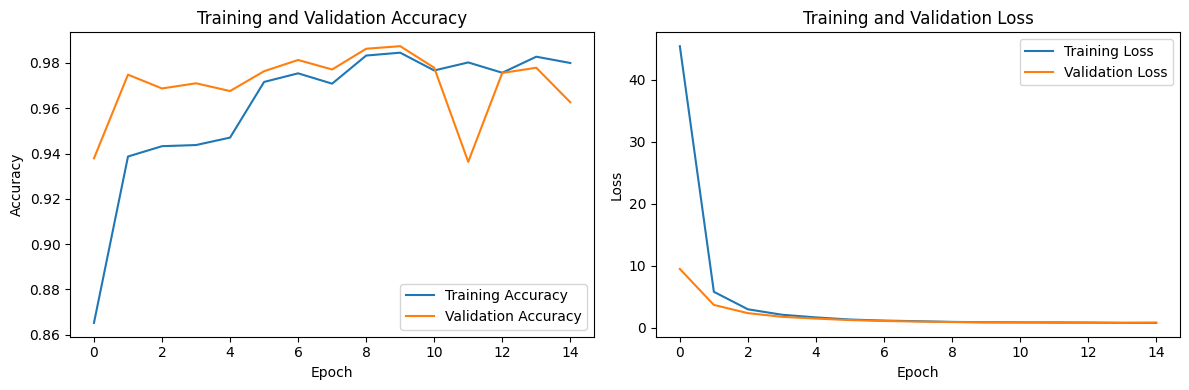

In [ ]:
# Находим лучшую модель
best_model_name = max(results, key=lambda k: results[k]['roc_auc'])
best_model_results = results[best_model_name]

# Доступ к показателям производительности
best_test_acc = best_model_results['test_accuracy']
best_cm = best_model_results['confusion_matrix']
best_report = best_model_results['classification_report']
best_auc = best_model_results['roc_auc']
best_history = best_model_results['history']

print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {best_test_acc * 100:.2f}%")
print("Confusion Matrix:")
print(best_cm)
print("Classification Report:")
print(best_report)
print(f"ROC AUC: {best_auc:.2f}")

# Рисуем метрики точности и потерь обучающей и валидационной выборки

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(best_history['accuracy'], label='Training Accuracy')
plt.plot(best_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_history['loss'], label='Training Loss')
plt.plot(best_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Загрузка сохраненной модели
best_model = load_model('/content/best_model.h5')
# Предположим, что мы настроили 'test_set', как упоминалось ранее
predictions = best_model.predict(test_set)
predicted_labels = (predictions > 0.5).astype(int)
true_labels = test_set.classes

# Рассчитываем классификационный отчет и матрицу ошибок
print(classification_report(true_labels, predicted_labels))
conf_matrix = confusion_matrix(true_labels, predicted_labels)

23/23 [==============================] - 6s 227ms/step
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       262
           1       1.00      0.93      0.96       453

    accuracy                           0.95       715
   macro avg       0.94      0.96      0.95       715
weighted avg       0.96      0.95      0.95       715



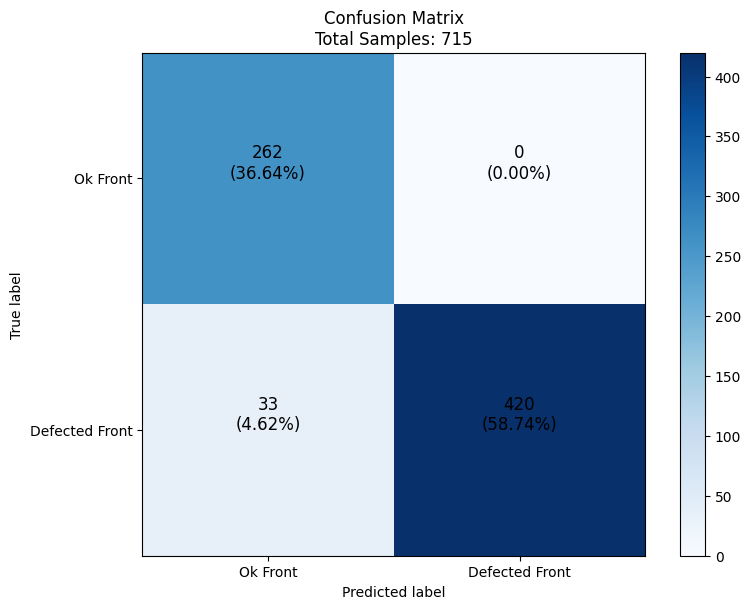

In [ ]:
# Предположим, что у вас есть 'conf_matrix', рассчитанная как матрица ошибок
total_samples = np.sum(conf_matrix)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title(f'Confusion Matrix\nTotal Samples: {total_samples}')
plt.colorbar()
tick_marks = np.arange(2)  # Предположим, что у вас есть 2 класса (0 и 1)
plt.xticks(tick_marks, ['Ok Front', 'Defected Front'])
plt.yticks(tick_marks, ['Ok Front', 'Defected Front'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Добавим числа внутри ячеек, используя черный цвет и проценты
for i in range(2):
    for j in range(2):
        count = conf_matrix[i, j]
        percentage = (count / total_samples) * 100
        plt.text(j, i, f'{count}\n({percentage:.2f}%)', horizontalalignment='center', color='black', fontsize=12)

plt.show()

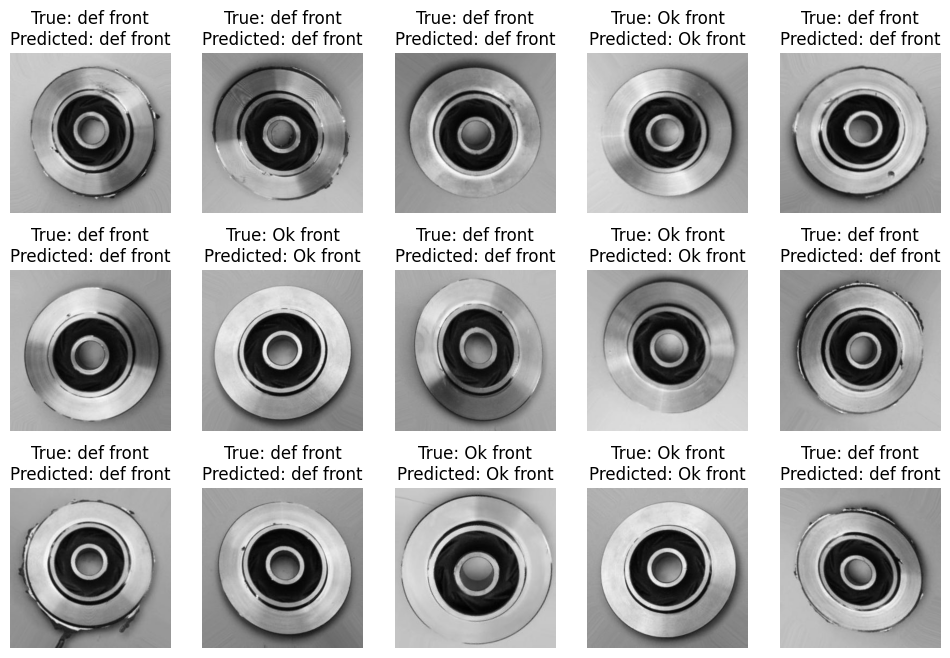

In [ ]:
num_samples_to_display = 15
nbr_samples_every_row = 5
rows = num_samples_to_display // nbr_samples_every_row
random.seed(30)

total_samples = len(test_set.filenames)

# Генерирование случайных индексов для отбора случайных выборок
random_indices = random.sample(range(total_samples), num_samples_to_display)

# Инициализация списка для хранения выбранных изображений, истинных и предсказанных значений
random_sample_data = []

# Извлечение случайных изображений, истинных и предсказанных значений
for idx in random_indices:
    image_path = test_set.filepaths[idx]
    true_label = test_set.classes[idx]
    image = plt.imread(image_path)
    predicted_label = predicted_labels[idx]
    true_label_text = "def front" if true_label == 1 else "Ok front"
    predicted_label_text = "def front" if predicted_label == 1 else "Ok front"
    random_sample_data.append((image, true_label_text, predicted_label_text))

# Визуализация изображений случайной выборки с истинными и предсказанными значениями
plt.figure(figsize=(12, 8))
for i, (image, true_label_text, predicted_label_text) in enumerate(random_sample_data):
    plt.subplot(rows, nbr_samples_every_row, i + 1)
    plt.imshow(image)
    plt.title(f'True: {true_label_text}\nPredicted: {predicted_label_text}')
    plt.axis('off')
plt.show()